In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [3]:
from TorchExperts import EachModelLinear, HyperModelNN, MixtureExpert, RegularizeModel

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
N = 5000
n = 3
r1 = 0.5
r2 = 1.5
phi = np.linspace(0, 2*np.pi, N)

x0 = 0
y0 = 0

x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0])
# x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0, 4*(np.random.rand(500)-0.5) + x0])
x += 0.05*np.random.randn(x.shape[0])
y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0])
# y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0, 4*(np.random.rand(500)-0.5) + y0])
y += 0.05*np.random.randn(y.shape[0])


# Likelihood proccesing

In [68]:
def log_likelihood(Y, X, model):
    """
        Args:
            X: Tensor, has a shape batch_size x n
            Y: Tensor, has a shape batch_size x 1
            model: mixture of experts model
        
        Returns:
            log likelihood without prior
    """
    pi = F.softmax(model.HyperModel(X), dim = -1)
    m = torch.cat([model.ListOfModels[0](X), model.ListOfModels[1](X)], dim = 1)
    
    
    return torch.logsumexp(torch.log(pi)*2.0/(model.HyperParameters['beta'] + 1e-15)*((Y_tr-m)**2), dim = 1).mean().item()

In [69]:
def extract_picture(model):
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

    CIRCLE = np.zeros_like(TEMP)

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r
        
    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    return CIRCLE, idx

In [70]:
x = scale(x)
y = scale(y)

x, y = shuffle(x, y)

x = x[:100]
y = y[:100]

In [71]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

In [72]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([100, 3]), torch.Size([100, 1]))

In [73]:
K = 2
LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

HypPar = {'beta': 1, 'alpha': 0.00}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

# model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)

# model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)



In [ ]:
List_of_log_likehood = [log_likelihood(Y_tr, X_tr, model)]

In [78]:
for _ in tqdm(range(100)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    
    List_of_log_likehood.append(log_likelihood(Y_tr, X_tr, model))

In [79]:
CIRCLE, idx = extract_picture(model)

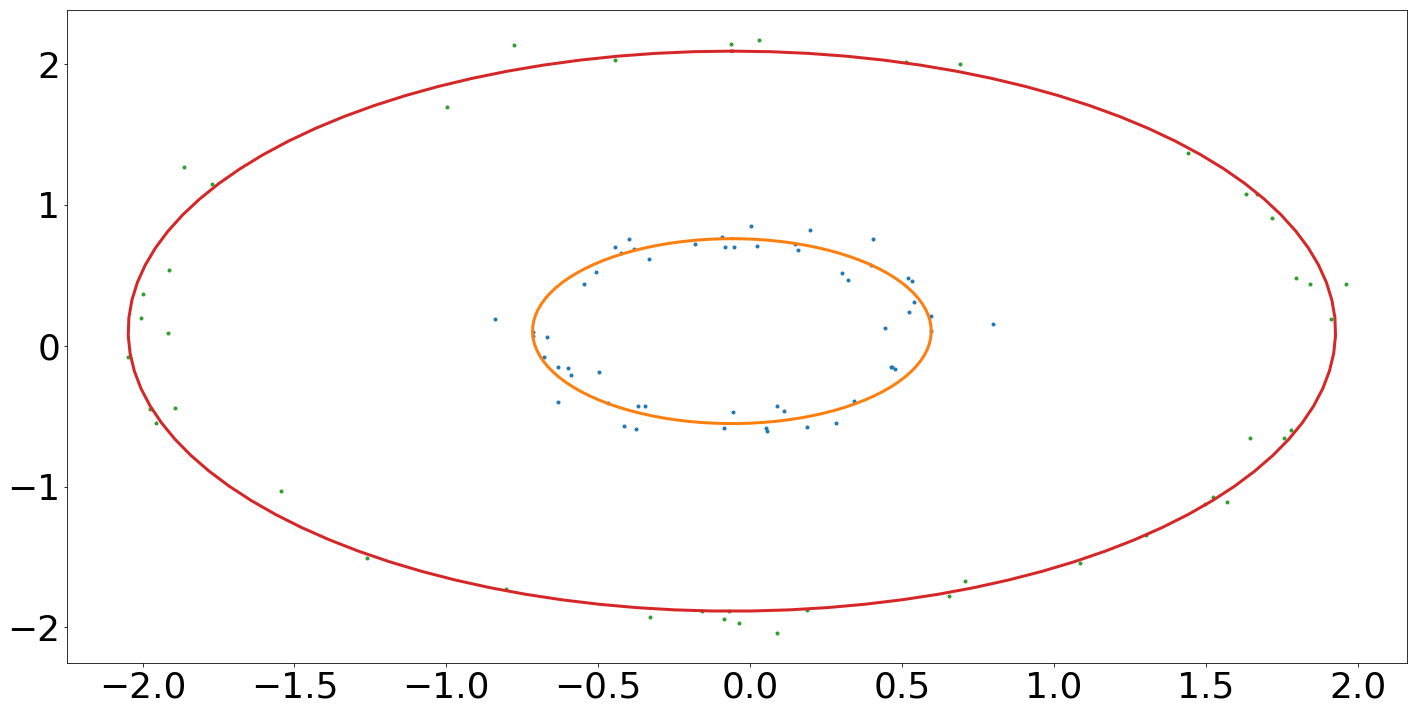

In [80]:
t = np.linspace(0, 2*np.pi, 100)

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-')

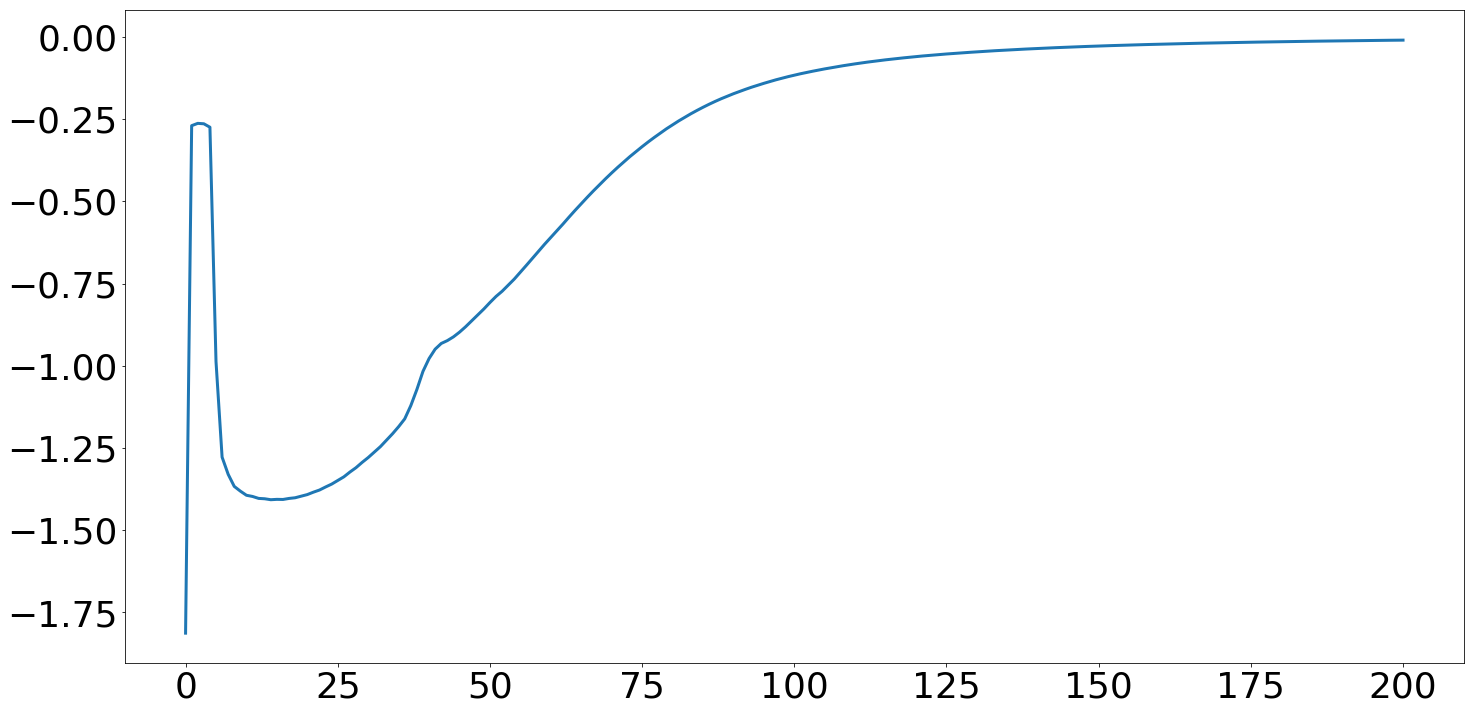

In [81]:
_ = plt.plot(List_of_log_likehood)